### Homework 3: covariate shift and deep ensembles
CS-229 Spring 2023

In [1]:
import torch as t
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.init as init 
import torch.nn.functional as F 
%matplotlib inline
t.manual_seed(1) 


class MyClassifier(t.nn.Module):
    """TODO: 2 points. Define your classifier. Note that my viz code below
    assumes outputs are logits."""

    def __init__(self, input_size, hidden_sizes, n_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0]) 
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], n_classes) 


        self._initialize_weights()     
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.bn2(x)
        x = self.fc3(x)

        return x

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.uniform_(module.weight, -1, 1)
                #init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
                              
class MyEnsemble(t.nn.Module):
    """TODO: 2 points, ensembled model
    This class implements an ensemble classifier from a list of models.
    Note that my viz code below assumes outputs are all logits. 
    """
    def __init__(self, models):
        super().__init__() 
        self.models = models 
        
    def forward(self, x):
        logits = [] 
        for model in self.models: 
            output = model(x) 
            logits.append(output) 
            
        stacked_logits = t.stack(logits, dim=1) 
        aggregated_logits = t.mean(stacked_logits, dim=1) 

        return aggregated_logits 


# Load data and construct train dataloaders
x_train, y_train, x_val, y_val, x_test, y_test = t.load('data.pt')
print('dataset sizes: ', x_train.shape, x_val.shape, x_test.shape)
batch_size = 100
train_ds = t.utils.data.TensorDataset(x_train, y_train)
train_dl = t.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True) 
val_ds = t.utils.data.TensorDataset(x_val, y_val)
val_dl = t.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True) 



dataset sizes:  torch.Size([2000, 2]) torch.Size([2000, 2]) torch.Size([1000, 2])


In [2]:
def ts2onehot(labels, num_classes):
    one_hot_labels = t.zeros((labels.size(0), num_classes))
    one_hot_labels[t.arange(labels.size(0)), labels.long()] = 1 
    return one_hot_labels

In [20]:
def run_model(model, optimizer, num_epochs, train_dl, val_dl):  # helper function to run model with different hyperparameter 
    criterion = nn.BCEWithLogitsLoss() 
    for epoch in range(num_epochs):
        # Batch wise train and optimize. bookkeeping of train loss and accuracy. 
        tr_loss = 0 
        tot_correct = 0 
        tot_sample = 0 
        for inputs, labels in train_dl:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, ts2onehot(labels, 2))
            tr_loss += loss.item()
            _, predicted_labels = t.max(outputs, 1)
            tot_correct += (predicted_labels == labels).sum().item()
            tot_sample += labels.size(0)
            loss.backward()
            optimizer.step()

        tr_acc = tot_correct / tot_sample
        tr_loss = tr_loss / len(train_dl.dataset)
        
        # Batch wise validation of the trained model in this epoch. bookkeeping of test loss and accuracy. 
        model.eval()  
        total_correct = 0
        total_samples = 0
        val_loss = 0 
        with t.no_grad():
            for inputs, labels in val_dl:
                outputs = model(inputs)
                predicted_labels = t.argmax(outputs, dim=1) 
                val_loss += criterion(outputs, ts2onehot(labels, 2)) 
                total_correct += (predicted_labels == labels).sum().item()
                total_samples += labels.size(0)
        val_acc = total_correct / total_samples 
        val_loss = val_loss/total_samples 
        if(epoch and (epoch+1)%100 == 0):
            print(f"Model:{i} Epoch:{epoch+1} loss:{tr_loss:0.5f} acc:{tr_acc:0.3f} val_loss:{val_loss:0.5f} val_acc: {val_acc:0.3f}")
    return model, val_acc 


# Create and train models
n_models = 10
models = []
val_acc0 = [] 

for i in range(n_models):
    model = MyClassifier(2, [8, 16], 2)
    
    # TODO: 2 points. Train each model on train_dl.
    learning_rate = 0.00015
    num_epochs = 100 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) 
    model, val_acc = run_model(model, optimizer, num_epochs, train_dl, val_dl)
    
    models.append(model)  # store them for evaluation and ensembling
    val_acc0.append(val_acc) 

model_ens = MyEnsemble(models)  # Construct the ensemble model



Model:0 Epoch:100 loss:0.00052 acc:0.989 val_loss:0.00059 val_acc: 0.986
Model:1 Epoch:100 loss:0.00021 acc:0.997 val_loss:0.00022 val_acc: 0.995
Model:2 Epoch:100 loss:0.00023 acc:0.994 val_loss:0.00027 val_acc: 0.991
Model:3 Epoch:100 loss:0.00039 acc:0.992 val_loss:0.00049 val_acc: 0.989
Model:4 Epoch:100 loss:0.00022 acc:0.994 val_loss:0.00027 val_acc: 0.992
Model:5 Epoch:100 loss:0.00048 acc:0.993 val_loss:0.00057 val_acc: 0.990
Model:6 Epoch:100 loss:0.00015 acc:0.997 val_loss:0.00016 val_acc: 0.995
Model:7 Epoch:100 loss:0.00022 acc:0.992 val_loss:0.00026 val_acc: 0.989
Model:8 Epoch:100 loss:0.00024 acc:0.996 val_loss:0.00026 val_acc: 0.994
Model:9 Epoch:100 loss:0.00042 acc:0.990 val_loss:0.00042 val_acc: 0.988


In [21]:
for model in models:
    outputs = model(x_test)
    predicted_labels = t.max(outputs, dim=1).indices 
    lb = y_test
    accuracy = (predicted_labels == lb).sum().item()/lb.size(0)
    print(accuracy) 

0.886
0.788
0.858
0.443
0.914
0.453
0.896
0.537
0.741
0.75


In [24]:
from torchsummary import summary
summary(model, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              24
              ReLU-2                    [-1, 8]               0
       BatchNorm1d-3                    [-1, 8]              16
            Linear-4                   [-1, 16]             144
              ReLU-5                   [-1, 16]               0
           Dropout-6                   [-1, 16]               0
       BatchNorm1d-7                   [-1, 16]              32
            Linear-8                    [-1, 2]              34
Total params: 250
Trainable params: 250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Output the accuracy and expected calibration error, for the model and ensemble

In [22]:
def accuracy(model, x, y):
    # TODO: 1 point accuracy function 
    outputs = model(x)
    predicted_labels = t.max(outputs, dim=1).indices 
    accuracy = t.mean((predicted_labels == y).float())
    return accuracy 

def ece(model, x, y, bins=10): 
    # TODO: expected calibration error, 2 point
    model.eval()
    with t.no_grad():
        logits = model(x)
    probabilities = F.softmax(logits, dim=1)
    predicted_labels = t.max(probabilities, dim=1).indices 
    confidences, _ = t.max(probabilities, dim=1) # confidence for each sample (max predicted probability) 
    
    bin_edges = t.linspace(0, 1, bins + 1) 
    bin_confidences = t.zeros(bins)
    bin_accuracies = t.zeros(bins)
    bin_frac = t.zeros(bins)
    for i in range(bins):
        bin_mask = ((confidences >= bin_edges[i]) & (confidences < bin_edges[i+1])) # samples that fall into the current bin
        bin_size = t.sum(bin_mask).item()
        # print(f"#of sample with confidence between {bin_edges[i]:0.2f} and {bin_edges[i+1]:0.2f} = {bin_size}")
        if bin_size == 0:
            continue
        bin_confidences[i] = t.mean(confidences[bin_mask])                      # mean confidence in the bin 
        bin_accuracies[i] = t.mean((predicted_labels == y)[bin_mask].float())    # mean acc in the bin 
        bin_frac[i] = t.sum(bin_mask) / x.size(0)                                  # frac of data in this bin 
        
    ece = t.sum(t.abs(bin_accuracies - bin_confidences) * bin_frac)
    
    return ece.item(), bin_confidences, bin_accuracies
    
    
# TODO (1 point): run accuracy/ece on models/data to generate table.
# Don't forget to turn off grad tracking and use eval mode, 
# It's good practice even it doesn't make much difference here. 

# Feel free to use my code below that automatically outputs a nice table.
# Pandas can output latex tables too, very convenient. 

def vector_of_results(model):
    columns = ['Acc-train', 'Acc-val', 'Acc-test', 
               'ECE-train', 'ECE-val', 'ECE-test']
    results = t.zeros(6)
    results[0] = accuracy(model, x_train, y_train)
    results[1] = accuracy(model, x_val, y_val)
    results[2] = accuracy(model, x_test, y_test)
    results[3], c, a = ece(model, x_train, y_train)
    results[4], c, a = ece(model, x_val, y_val)
    results[5], c, a = ece(model, x_test, y_test)
    return columns, results

with t.no_grad():
    results = t.zeros(6, 10)  # accuracy/ECE for train/val/test, then model index
    for i, model in enumerate(models):
        model.eval()  
        columns, results[:,i] = vector_of_results(model) 
    print("All model performance=> ")
    print(pd.DataFrame(results.T.numpy(), columns=columns))
    results = results.mean(axis=1) 
    columns, ens_results = vector_of_results(model_ens)

print("\nMean of Individual model Vs. Ensemble=>")
df = pd.DataFrame(data=[results.numpy(), ens_results.numpy()], index=['Mean of models', 'Ensemble model'], columns=columns)
precision = '{:.3f}'.format
print(df.to_string(float_format=precision))

All model performance=> 
   Acc-train  Acc-val  Acc-test  ECE-train   ECE-val  ECE-test
0     0.9885   0.9860     0.886   0.004988  0.003549  0.054899
1     0.9965   0.9950     0.788   0.002623  0.002758  0.162236
2     0.9935   0.9910     0.858   0.003812  0.005115  0.085400
3     0.9925   0.9885     0.443   0.003044  0.006583  0.517219
4     0.9935   0.9920     0.914   0.003857  0.003769  0.028548
5     0.9925   0.9895     0.453   0.002689  0.004467  0.434648
6     0.9965   0.9950     0.896   0.001126  0.002687  0.051016
7     0.9920   0.9890     0.537   0.004468  0.006895  0.415335
8     0.9955   0.9935     0.741   0.001371  0.004537  0.144343
9     0.9895   0.9880     0.750   0.003921  0.002855  0.198285

Mean of Individual model Vs. Ensemble=>
                Acc-train  Acc-val  Acc-test  ECE-train  ECE-val  ECE-test
Mean of models      0.993    0.991     0.727      0.003    0.004     0.209
Ensemble model      0.998    0.996     0.838      0.002    0.003     0.059


### Visualize the results

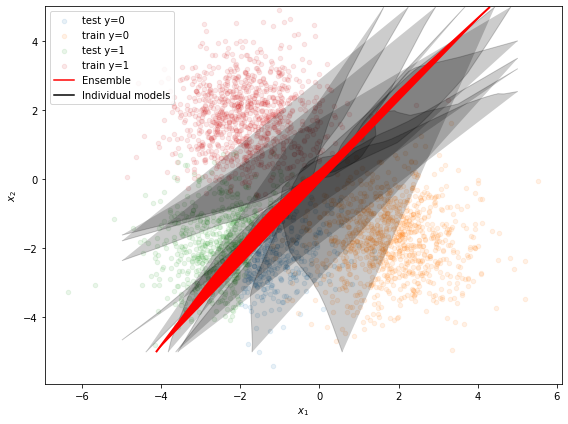

In [23]:
# Feel free to use my code or make your own. 

# viz datasets
fig, ax = plt.subplots(figsize=(8,6))

for label in [0, 1]:
    ax.scatter(x_test[y_test==label, 0],x_test[y_test==label, 1], s=20, alpha=0.1, label='test y='+str(label))
    ax.scatter(x_train[y_train==label, 0],x_train[y_train==label, 1], s=20, alpha=0.1, label='train y='+str(label))

# Contour plot
k = 200
X = t.stack(t.meshgrid(t.linspace(-5, 5, k), t.linspace(-5, 5, k))).reshape((2, -1)).T
xx = X[:,0].reshape((k,k))
yy = X[:,1].reshape((k,k))

with t.no_grad():
    for i, model in enumerate(models):
        pred = t.softmax(model(X), axis=1)[:,0].numpy()
        zz = pred.reshape((k,k)).astype('float')
        contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=0.2)

        contour.collections[0].set_color('black')
        contour.collections[0].set_linewidth(1)
        # contour.collections[0].set_label('model '+str(i))
        
    pred = t.softmax(model_ens(X), axis=1)[:,0].numpy()
    zz = pred.reshape((k,k)).astype('float')
    contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=1)

    contour.collections[0].set_color('red')
    contour.collections[0].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
from matplotlib.lines import Line2D
line = Line2D([0], [0], label='Ensemble', color='red')
line2 = Line2D([0], [0], label='Individual models', color='black')
# add manual symbols to auto legend
handles.extend([line, line2])
    
ax.legend(handles=handles, loc='upper left')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.tight_layout()

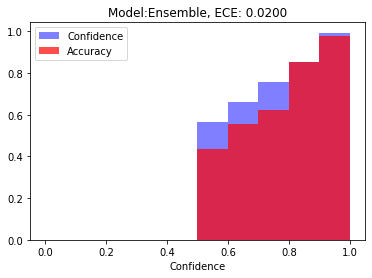

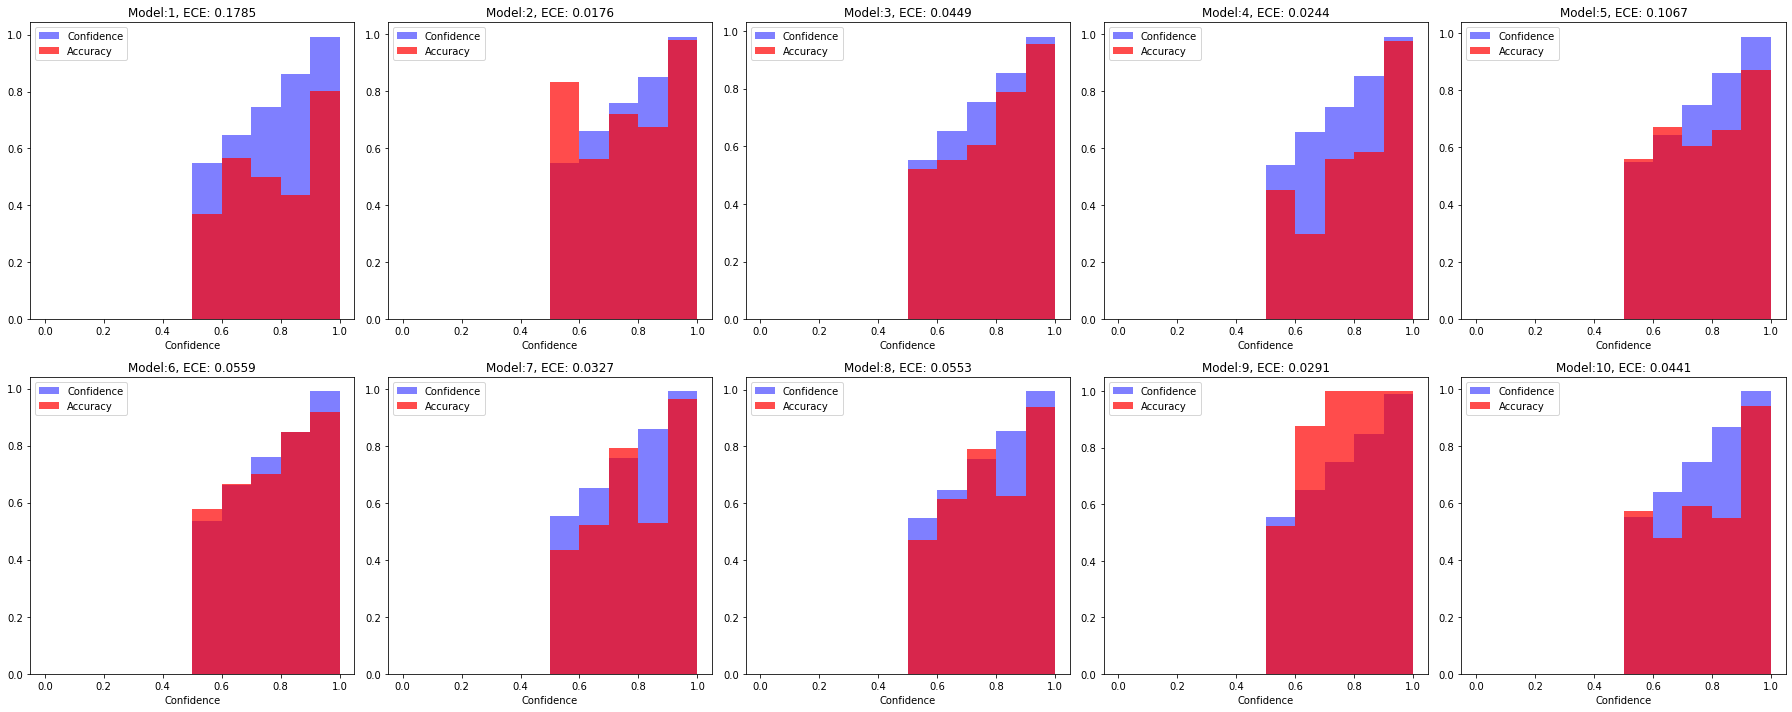

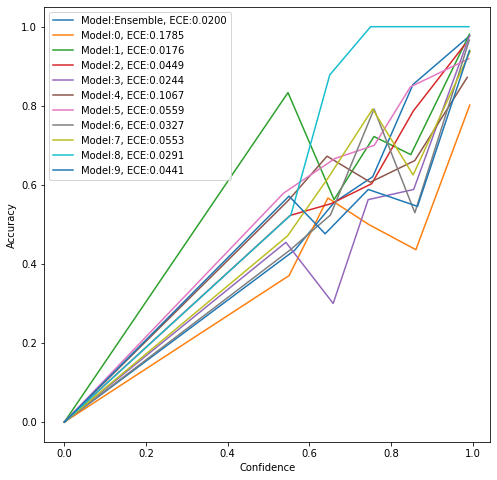

In [6]:
X = x_test   
Y = y_test   

def plot_ece(model, x, y, bins=10, titl = ""):
    ece_value, bin_confidences, bin_accuracies = ece(model, x, y, bins)

    # Plotting ECE
    bin_edges = t.linspace(0, 1, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    ax = plt.gca()
    ax.bar(bin_centers, bin_confidences, width=(1 / bins), align='center', color='blue', alpha=0.5, label='Confidence')
    ax.bar(bin_centers, bin_accuracies, width=(1 / bins), align='center', color='red', alpha=0.7, label='Accuracy')

    ax.set_xlabel('Confidence')
    #ax.set_ylabel('Mean Accuracy / Mean Confidence')
    ax.set_title(f'Model:{titl}, ECE: {ece_value:.4f}')
    ax.legend()

    return ax

# bar plot of confidences and accuracies 
plot_ece(model_ens, X, Y, bins=10, titl="Ensemble") 
plt.figure(figsize=(25, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plot_ece(models[i], X, Y, bins=10, titl=str(i+1))
plt.tight_layout()   
plt.show() 

# confidence vs accuracy in bins 
plt.figure(figsize=(8,8))
ece_value, bin_confidences, bin_accuracies = ece(model_ens, X, Y, bins=10)
plt.plot(bin_confidences, bin_accuracies, label=f"Model:Ensemble, ECE:{ece_value:0.4f}")
for i in range(10):
    ece_value, bin_confidences, bin_accuracies = ece(models[i], X, Y, bins=10)
    plt.plot(bin_confidences, bin_accuracies, label=f"Model:{i}, ECE:{ece_value:0.4f}") 
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
plt.show()
